In [1]:
n_wide = 26
n_deep = 48

In [2]:
import numpy as np
import h5py
import time
import pandas as pd
import matplotlib.pyplot as plt
import glob
import scipy
import pickle as pkl
import matplotlib as mpl
from astropy.coordinates import SkyCoord
from astropy import units as u

In [3]:
def flux2mag(flux):
    return -2.5 * np.log10(flux) + 30

balrog_term = np.load('/project/chihway/raulteixeira/data/BalrogTerm_v02_29072023.npy')
wide = pd.read_csv('/project/chihway/raulteixeira/data/BalorgOfTheDECADE_v01_29072023_cells_wide_26x26.csv.gz')
deep = pd.read_csv('/project/chihway/raulteixeira/data/deep_fields_nice_n_z.csv.gz')
wide_deep = pd.read_csv('/project/chihway/raulteixeira/data/BalorgOfTheDECADE_v01_29072023_cells_wide_deep_26x26.csv.gz')

wide['ID']=wide.coadd_object_id
wide_deep['wide_cells']=wide_deep.cells_x
wide_deep['deep_cells']=wide_deep.cells_y

In [4]:
fun = 'len'
feat = 'ID'
square_len_deep = deep[[feat, 'cells']].groupby('cells').agg(['mean', 'median', 'std', len])

counts_deep = square_len_deep[(feat, fun)].values

square_len_wide = wide[[feat, 'cells']].groupby('cells').agg(['mean', 'median', 'std', len])

counts_wide = square_len_wide[(feat, fun)].values

In [5]:
p_c = counts_deep/np.sum(counts_deep) #note this p_c is the probability for all galaxies in the deep field catalog
                     #QUESTION: When balrog is done, will this be the same as the p_c in SOM_D2W_balrog.ipynb?
    
p_c_hat = counts_wide/np.sum(counts_wide)

In [6]:
# multiplying p_c, balrog_term, and p_c_hat

In [7]:
joint_cell_weight = p_c * balrog_term * p_c_hat[:,None]

In [8]:
joint_cell_weight

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00985289, 0.        , 0.00985289, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02669501, 0.        , 0.05339002, ..., 0.        , 0.        ,
        0.        ]])

In [9]:
def func(df):
    """
    returns numpy array of dataframe given
    """
    col = df
    return list(np.array(df))

In [10]:
def hist(a):
    return list(np.histogram(a, bins=np.linspace(0,2,30), density=False)[0])

In [11]:
fun = 'len'
feat = 'Z'
cell_z = deep[[feat, 'cells']].groupby('cells').agg(func=hist)

#counts_deep = square_len_deep[(feat, fun)].values

In [12]:
cell_z

,Z
cells,
0,"[7, 7, 8, 8, 10, 7, 3, 6, 11, 13, 20, 4, 6, 2,..."
1,"[1, 0, 1, 1, 2, 0, 4, 2, 3, 2, 4, 1, 0, 3, 5, ..."
2,"[1, 1, 0, 1, 0, 1, 0, 3, 4, 2, 4, 7, 5, 6, 10,..."
3,"[1, 0, 0, 0, 0, 0, 0, 1, 2, 4, 9, 13, 9, 12, 1..."
4,"[0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 8, 20, 9, 13, 1..."
...,...
2299,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 6, 11, 9, 8, 0,..."
2300,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 8, 7, 3, 1, 0, ..."
2301,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 11, 3, 0, 0,..."


In [13]:
np.unique(deep[np.isfinite(deep['Z'])].cells.values).size

2284

In [14]:
rangedeep = np.arange(0, n_deep**2)

In [15]:
missing_indices = rangedeep[~np.isin(rangedeep, cell_z['Z'].index)]

In [16]:
missing_indices

array([], dtype=int64)

In [17]:
np.sum(p_c[missing_indices])

0.0

In [18]:
p_z_c = np.array([cell_z['Z'][cell] for cell in cell_z['Z'].index])

zero_mask = np.sum(p_z_c, axis=1)==0
nonzero_indices = rangedeep[~zero_mask]

p_z_c = p_z_c[nonzero_indices].astype('float64')
p_z_c /= np.sum(p_z_c, axis=1)[:,None]

In [19]:
p_z_c_hat = (joint_cell_weight[:,nonzero_indices]@p_z_c)

In [20]:
p_z_c_hat

array([[1.19412470e-01, 1.47122521e-01, 2.75967874e-01, ...,
        1.83916430e-01, 7.78406774e-02, 2.01724048e-01],
       [1.23552152e-06, 9.01674065e-06, 1.54518556e-05, ...,
        7.71830945e-07, 6.45244247e-07, 7.71830945e-07],
       [2.37499806e-06, 2.60269350e-06, 1.69408377e-05, ...,
        9.12795424e-06, 3.14298436e-06, 5.50374031e-06],
       ...,
       [2.43454235e-04, 3.46667085e-04, 5.35197503e-04, ...,
        1.49447327e-03, 8.59026402e-04, 1.26267566e-03],
       [4.41585448e-05, 1.76071389e-04, 2.25115126e-04, ...,
        5.64992146e-05, 2.77201633e-05, 3.01790047e-05],
       [1.50032636e-03, 2.47222015e-03, 2.52010636e-03, ...,
        4.66838667e-03, 2.87512371e-03, 4.08238007e-03]])

In [21]:
np.isnan(np.sum(p_z_c, axis=1)).sum()

0

In [22]:
wide.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Ai', 'Ar', 'Az', 'FLUX_i', 'FLUX_i_ERR',
       'FLUX_r', 'FLUX_r_ERR', 'FLUX_z', 'FLUX_z_ERR', 'Truth_ind',
       'coadd_object_id', 'd_arcsec', 'dec', 'detected', 'ra', 'true_FLUX_i',
       'true_FLUX_r', 'true_FLUX_z', 'true_dec', 'true_ra', 'cells', 'ID'],
      dtype='object')

In [23]:
wide_arr = np.load('/project/chihway/raulteixeira/data/BPZ+SOM_mcal_gold_wide_26x26_ids+cells+fluxes_TomoBins.npz')['arr_0']



In [24]:
wide = pd.DataFrame(wide_arr)

In [25]:
wide_arr['TomoBin']

array([1, 4, 1, ..., 3, 2, 4])

In [26]:
Tomo_cells = np.load('/project/chihway/raulteixeira/data/TomoBins_cell_wide_26x26.npz')

p_z_c_hat[Tomo_cells[f'bin0_cells']].sum(axis=0).shape

p_z_c_hat_bins = [np.sum(p_z_c_hat[Tomo_cells[f'bin{i}_cells']], axis=0) for i in range(4)]

In [29]:
[np.sum(p_z_c_hat_bins[i]/np.sum(p_z_c_hat_bins[i]) * np.linspace(0, 2, 30)[:-1]) for i in range(4)]

[0.46856633258545066,
 0.7394049976231342,
 0.8789209738509907,
 0.9186412993602125]

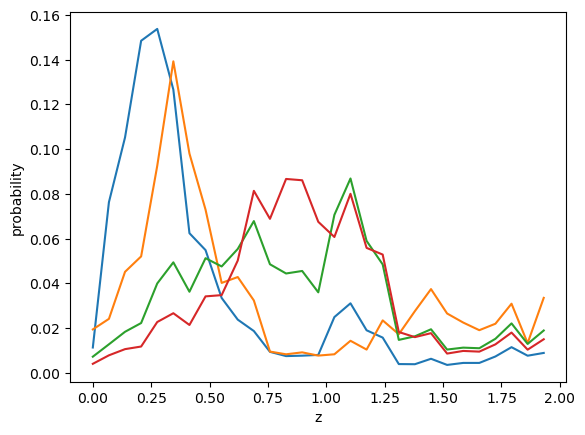

In [30]:
plt.figure()
plt.xlabel('z')
plt.ylabel('probability')
for i in range(4):
    plt.plot(np.linspace(0, 2, 30)[:-1], p_z_c_hat_bins[i]/np.sum(p_z_c_hat_bins[i]))
plt.show()

In [31]:
# make SOM plot of mean redshift of each cell according to deepfields+balrog
# three panels: BPZ, deepfields+balrog, difference

In [32]:
p_z_c_hat_n  = p_z_c_hat/np.sum(p_z_c_hat, axis=1)[:,None]

/tmp/jobs/30179261/ipykernel_150954/3623405601.py:1: RuntimeWarning: invalid value encountered in divide
  p_z_c_hat_n  = p_z_c_hat/np.sum(p_z_c_hat, axis=1)[:,None]


In [33]:
#p_z_c_hat_n = np.where(np.sum(p_z_c_hat, axis=1)>0, p_z_c_hat/np.sum(p_z_c_hat, axis=1)[:,None], 0)

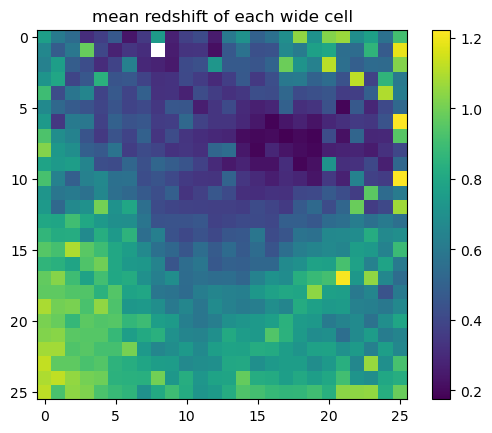

In [34]:
plt.title('mean redshift of each wide cell')
zs_ = np.linspace(0, 2, 30)
zs = np.array([.5*(zs_[i]+zs_[i+1]) for i in range(29)])
plt.imshow(np.sum((p_z_c_hat_n*zs), axis=1).reshape(n_wide, n_wide))
plt.colorbar()

In [150]:
25+26*6+17

198

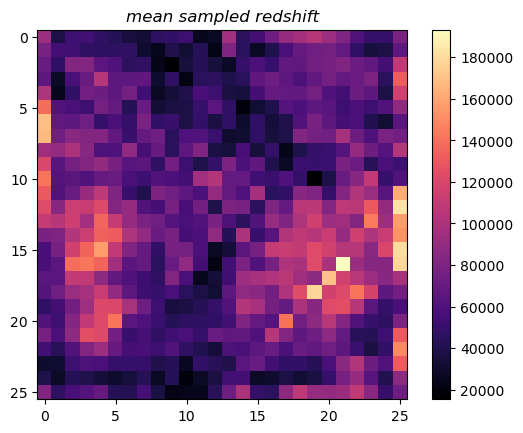

In [157]:
cmap='magma'
fun = 'len'
feat = 'Z_SAMP'
vmin,vmax=None,None#-1,3
norm=None
title = 'mean sampled redshift'
square = wide[[feat, 'cells']].groupby('cells').agg(['mean', 'median', 'std', len])
im_z = square[(feat, fun)].values.reshape(n_wide,n_wide)
image = plt.imshow(im_z, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
#divider = make_axes_locatable(axes[i,j])
#cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(image, orientation='vertical') # cax=cax
plt.title(f'{title}',style='italic')
plt.show()

Text(0.5, 1.0, 'Mean redshift of Wide cells')

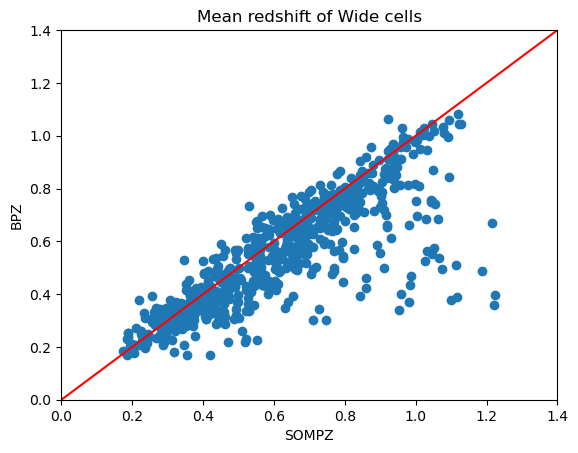

In [36]:
plt.scatter(np.sum((p_z_c_hat_n*zs), axis=1), im_z.flatten())
plt.xlim(0,1.4)
plt.ylim(0,1.4)
plt.plot([0,1.4],[0,1.4], c='red')
plt.xlabel('SOMPZ')
plt.ylabel('BPZ')
plt.title('Mean redshift of Wide cells')

In [37]:
# questions
    # look at the deep field colors of outlier cells (verify they have similar colors)
    # (see if we have high redshift and low redshift with same wide colors)
# compare balrog fluxes to DF fluxes

In [161]:
test21 = wide_deep[wide_deep['wide_cells']==21]

In [162]:
test21 

,Unnamed: 0,Unnamed: 0_x,Ai,Ar,Az,FLUX_i,FLUX_i_ERR,FLUX_r,FLUX_r_ERR,FLUX_z,...,j-i,h-i,ks-i,zspec,paus_z,cosmos_z,Z,good_Z,wide_cells,deep_cells
799,799,799,0.0,0.0,0.0,1342.27420,79.076200,844.25200,29.291073,529.680360,...,-0.803398,-0.873154,-1.159466,0.790900,NaN,NaN,0.790900,0.790900,21,302.0
1053,1053,1053,0.0,0.0,0.0,1086.22600,69.455860,766.22906,34.078907,655.510600,...,-0.266191,-0.360846,-0.418060,0.521761,NaN,NaN,0.521761,0.521761,21,714.0
2051,2051,2051,0.0,0.0,0.0,380.66687,35.368694,269.82712,15.933167,295.249100,...,-0.357959,-1.046522,-0.933430,NaN,NaN,NaN,NaN,NaN,21,288.0
2068,2068,2068,0.0,0.0,0.0,930.10050,91.039660,604.50750,25.502459,114.582610,...,-0.796417,-0.649098,-0.492191,NaN,NaN,NaN,NaN,NaN,21,97.0
2660,2660,2660,0.0,0.0,0.0,581.18590,79.448160,395.27026,34.770190,-5.130633,...,-0.242349,-0.227258,-0.367396,NaN,NaN,0.257222,0.257222,NaN,21,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116229,116229,116229,0.0,0.0,0.0,1309.64990,55.302456,877.93100,39.690130,724.958900,...,-0.328858,-0.501636,-0.595833,0.535500,0.535,0.541438,0.535500,0.535500,21,955.0
124078,124078,124078,0.0,0.0,0.0,924.21260,129.035310,646.07140,76.735245,523.219200,...,-0.392512,-0.510976,-0.475940,NaN,NaN,NaN,NaN,NaN,21,126.0
124597,124597,124597,0.0,0.0,0.0,493.69598,52.909782,312.12260,31.200970,125.544240,...,-0.324977,-0.441159,-0.412214,NaN,NaN,NaN,NaN,NaN,21,86.0
126121,126121,126121,0.0,0.0,0.0,580.03350,51.112990,428.96255,26.813715,353.242860,...,-0.334013,-0.314085,-0.531537,NaN,NaN,NaN,NaN,NaN,21,663.0


In [154]:
test197 = wide_deep[wide_deep['wide_cells']==197]

In [155]:
test197

,Unnamed: 0,Unnamed: 0_x,Ai,Ar,Az,FLUX_i,FLUX_i_ERR,FLUX_r,FLUX_r_ERR,FLUX_z,...,j-i,h-i,ks-i,zspec,paus_z,cosmos_z,Z,good_Z,wide_cells,deep_cells
67236,67236,67236,0.0,0.0,0.0,30498.105,80.57275,20900.1660,69.857544,36828.562,...,-0.701144,-0.993187,-1.269546,0.275800,NaN,NaN,0.275800,0.275800,197,1521.0
82766,82766,82766,0.0,0.0,0.0,46283.965,252.56170,33077.1700,146.574260,56018.203,...,-0.557521,-0.716790,-0.709297,0.138465,NaN,NaN,0.138465,0.138465,197,1376.0
99990,99990,99990,0.0,0.0,0.0,31923.379,270.22150,22685.2730,147.805900,38613.875,...,-0.507999,-0.665680,-0.622732,NaN,NaN,NaN,NaN,NaN,197,1329.0
105435,105435,105435,0.0,0.0,0.0,13002.437,110.32829,9008.8840,98.449990,16098.221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,197,NaN
113469,113469,113469,0.0,0.0,0.0,23621.766,186.36842,16906.1970,178.744450,29288.960,...,-0.608372,-0.798786,-1.026311,NaN,NaN,NaN,NaN,NaN,197,892.0
115156,115156,115156,0.0,0.0,0.0,10769.969,78.15078,7786.6587,73.977100,13356.573,...,-0.630714,-0.832648,-0.917676,NaN,NaN,NaN,NaN,NaN,197,1424.0
123597,123597,123597,0.0,0.0,0.0,63156.082,267.94860,43583.1560,152.018940,77660.664,...,-0.677234,-0.888589,-1.050769,0.219100,0.223,0.208615,0.219100,0.219100,197,1472.0


In [43]:
test21.columns

Index(['Unnamed: 0', 'Unnamed: 0_x', 'Ai', 'Ar', 'Az', 'FLUX_i', 'FLUX_i_ERR',
       'FLUX_r', 'FLUX_r_ERR', 'FLUX_z', 'FLUX_z_ERR', 'Truth_ind',
       'coadd_object_id', 'd_arcsec', 'dec', 'detected', 'ra', 'true_FLUX_i',
       'true_FLUX_r', 'true_FLUX_z', 'true_dec', 'true_ra', 'cells_x', 'ID',
       'Unnamed: 0_y', 'RA', 'DEC', 'KNN_CLASS', 'BDF_FLUX_DERED_CALIB_U',
       'BDF_FLUX_DERED_CALIB_G', 'BDF_FLUX_DERED_CALIB_R',
       'BDF_FLUX_DERED_CALIB_I', 'BDF_FLUX_DERED_CALIB_Z',
       'BDF_FLUX_DERED_CALIB_J', 'BDF_FLUX_DERED_CALIB_H',
       'BDF_FLUX_DERED_CALIB_KS', 'BDF_FLUX_ERR_DERED_CALIB_U',
       'BDF_FLUX_ERR_DERED_CALIB_G', 'BDF_FLUX_ERR_DERED_CALIB_R',
       'BDF_FLUX_ERR_DERED_CALIB_I', 'BDF_FLUX_ERR_DERED_CALIB_Z',
       'BDF_FLUX_ERR_DERED_CALIB_J', 'BDF_FLUX_ERR_DERED_CALIB_H',
       'BDF_FLUX_ERR_DERED_CALIB_KS', 'BDF_MAG_DERED_CALIB_I', 'cells_y',
       'u-g', 'g-r', 'r-i', 'i-z', 'z-J', 'J-H', 'H-KS', 'i', 'u-i', 'g-i',
       'z-i', 'j-i', 'h-i', 'ks

In [44]:
def flux2mag(flux):
    return -2.5 * np.log10(flux) + 30

bands = ['R', 'I', 'Z']
for band in bands:
    test21[f'BDF_MAG_DERED_CALIB_{band}']=flux2mag(test21[f'BDF_FLUX_DERED_CALIB_{band}'])

/tmp/jobs/30179261/ipykernel_150954/1550363332.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test21[f'BDF_MAG_DERED_CALIB_{band}']=flux2mag(test21[f'BDF_FLUX_DERED_CALIB_{band}'])
/tmp/jobs/30179261/ipykernel_150954/1550363332.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test21[f'BDF_MAG_DERED_CALIB_{band}']=flux2mag(test21[f'BDF_FLUX_DERED_CALIB_{band}'])


In [120]:
emptycells_deep = np.arange(0, n_deep**2)[~np.isin(np.arange(0, n_deep**2), test21.deep_cells.values)]
emptycells_wide = np.arange(0, n_wide**2)[~np.isin(np.arange(0, n_wide**2), test21.wide_cells.values)]

In [121]:
emptycells_deep.shape

(2196,)

In [112]:
lines = []
for cell in emptycells_deep:
    lines.append(pd.DataFrame({f"{col}": np.nan for col in square['BDF_MAG_DERED_CALIB_I'].columns}, index=[cell]))
    emptylines = pd.concat(lines, ignore_index=False)
    #print(cell)
print(emptylines)

      mean  median  std  len
1      NaN     NaN  NaN  NaN
2      NaN     NaN  NaN  NaN
3      NaN     NaN  NaN  NaN
5      NaN     NaN  NaN  NaN
6      NaN     NaN  NaN  NaN
...    ...     ...  ...  ...
2299   NaN     NaN  NaN  NaN
2300   NaN     NaN  NaN  NaN
2301   NaN     NaN  NaN  NaN
2302   NaN     NaN  NaN  NaN
2303   NaN     NaN  NaN  NaN

[2196 rows x 4 columns]


In [60]:
emptylines.index

Index([   1,    2,    3,    5,    6,    7,    8,    9,   10,   11,
       ...
       2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303],
      dtype='int64', length=2196)

In [73]:
for i in square['BDF_MAG_DERED_CALIB_I'].index:
    emptylines.loc[i]=square['BDF_MAG_DERED_CALIB_I'].loc[i]

In [78]:
np.argsort(emptylines.index)

array([2196,    0,    1, ..., 2193, 2194, 2195])

In [107]:
im = np.arange(0, n_deep**2)

In [108]:
im[np.array([square['BDF_MAG_DERED_CALIB_I'].index.astype(int)])[0]]=np.array(square['BDF_MAG_DERED_CALIB_I']['len'])

In [109]:
im

array([   1,    1,    2, ..., 2301, 2302, 2303])

In [87]:
pd.concat([square['BDF_MAG_DERED_CALIB_I'], emptylines])

,mean,median,std,len
0.0,23.606714,23.606714,NaN,1.0
4.0,23.391322,23.391322,NaN,1.0
16.0,23.374047,23.374047,NaN,1.0
18.0,23.337041,23.337041,NaN,1.0
19.0,23.721341,23.779493,0.453394,3.0
...,...,...,...,...
1194.0,23.332267,23.332267,NaN,1.0
1244.0,23.196247,23.196247,NaN,1.0
1295.0,23.744054,23.744054,NaN,1.0
1341.0,21.791648,21.791648,NaN,1.0


In [81]:
square

BDF_MAG_DERED_CALIB_I                         
                            mean     median       std len
deep_cells                                               
0.0                    23.606714  23.606714       NaN   1
4.0                    23.391322  23.391322       NaN   1
16.0                   23.374047  23.374047       NaN   1
18.0                   23.337041  23.337041       NaN   1
19.0                   23.721341  23.779493  0.453394   3
...                          ...        ...       ...  ..
1194.0                 23.332267  23.332267       NaN   1
1244.0                 23.196247  23.196247       NaN   1
1295.0                 23.744054  23.744054       NaN   1
1341.0                 21.791648  21.791648       NaN   1
1679.0                 21.931776  21.931776       NaN   1

[108 rows x 4 columns]

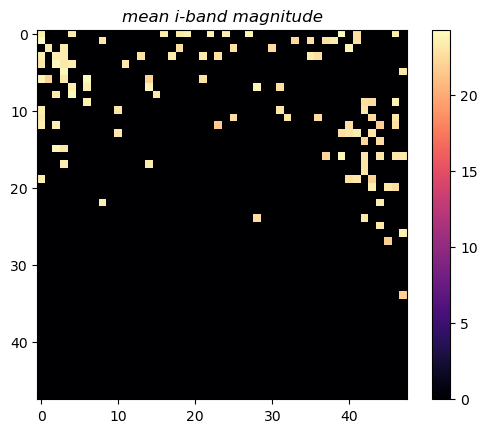

In [132]:
cmap='magma'
fun = 'mean'
feat = 'BDF_MAG_DERED_CALIB_I'
vmin,vmax=None,None#-1,3
norm=None
title = 'mean i-band magnitude'
square = test21[[feat, 'deep_cells']].groupby('deep_cells').agg(['mean', 'median', 'std', len])
im_i = np.zeros(n_deep**2)
im_i[np.array([square['BDF_MAG_DERED_CALIB_I'].index.astype(int)])[0]]=np.array(square['BDF_MAG_DERED_CALIB_I'][fun])
#im_z = square[(feat, fun)].values.reshape(n_deep,n_deep)
image = plt.imshow(im_i.reshape(n_deep, n_deep), cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
#divider = make_axes_locatable(axes[i,j])
#cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(image, orientation='vertical') # cax=cax
plt.title(f'{title}',style='italic')
plt.show()

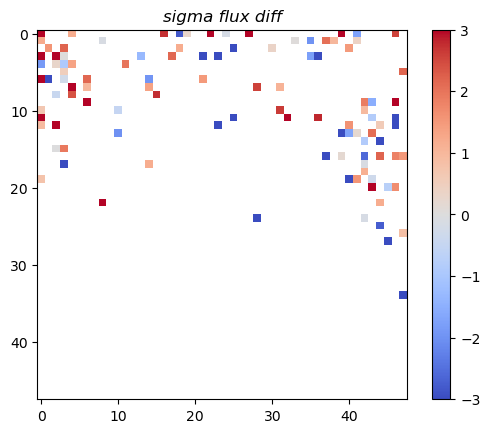

In [146]:
cmap='coolwarm'
fun = 'mean'
feat = 'diff_flux_i'
vmin,vmax=-3,3
norm=None
title = 'sigma flux diff'
square = test21[[feat, 'deep_cells']].groupby('deep_cells').agg(['mean', 'median', 'std', len])
im_i = np.zeros(n_deep**2)+np.nan
im_i[np.array([square[feat].index.astype(int)])[0]]=np.array(square[feat][fun])
#im_z = square[(feat, fun)].values.reshape(n_deep,n_deep)
image = plt.imshow(im_i.reshape(n_deep, n_deep), cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
#divider = make_axes_locatable(axes[i,j])
#cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(image, orientation='vertical') # cax=cax
plt.title(f'{title}',style='italic')
plt.show()

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  3.,  4.,  9., 16.,
        23., 30., 27.,  8.,  6.,  1.,  1.]),
 array([-23.81806081, -22.09580488, -20.37354895, -18.65129302,
        -16.92903709, -15.20678116, -13.48452524, -11.76226931,
        -10.04001338,  -8.31775745,  -6.59550152,  -4.87324559,
         -3.15098966,  -1.42873373,   0.2935222 ,   2.01577813,
          3.73803405,   5.46028998,   7.18254591,   8.90480184,
         10.62705777]),
 <BarContainer object of 20 artists>)

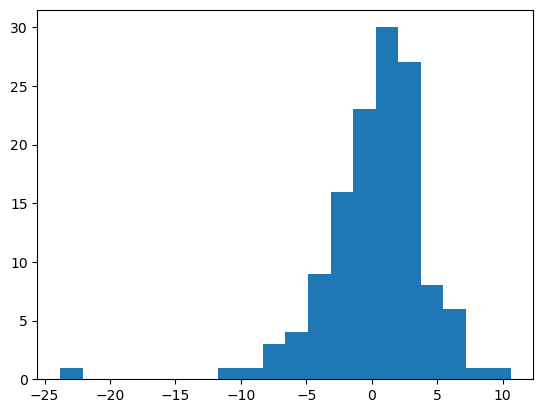

In [149]:
plt.hist(test21['diff_flux_i'], bins=20)

In [137]:
test21['diff_flux_i']=(test21['FLUX_i']-test21['BDF_FLUX_DERED_CALIB_I'])/test21['FLUX_i_ERR']

/tmp/jobs/30179261/ipykernel_150954/3392329499.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test21['diff_flux_i']=(test21['FLUX_i']-test21['BDF_FLUX_DERED_CALIB_I'])/test21['FLUX_i_ERR']


In [138]:
test21['diff_flux_i']

799      -1.938053
1053     -0.849762
2051      6.551252
2068      2.877417
2660     -1.721045
            ...   
116229   -0.324874
124078    0.337733
124597    0.985473
126121   -4.252384
127964    2.057336
Name: diff_flux_i, Length: 151, dtype: float64